In [1]:
import os
import datetime

import matplotlib.pyplot as plt
import matplotlib as mpl

import skimage
from skimage import data, img_as_float
import skimage.transform as trans

import rasterio
import fiona

import cartopy

import numpy as np

In [2]:
import sys

import cartopy.crs as ccrs
import cartopy.feature as cfeature

sys.path.append(r"..\..")
import pyphenocam

sys.path.append(r"J:\Projects\NCCSC\phenocam\Tools\DaymetPy\daymetpy")
import daymetpy

In [3]:
base_dname = r"J:\Projects\NCCSC\phenocam\DerivedData\nationalelkrefuge"
site_name = "nationalelkrefuge"

In [4]:
site = pyphenocam.dataaccess.get_site(site_name)
site.x, site.y

(-110.737824, 43.488931)

### Read in landsat data

LC80380302015230LGN00


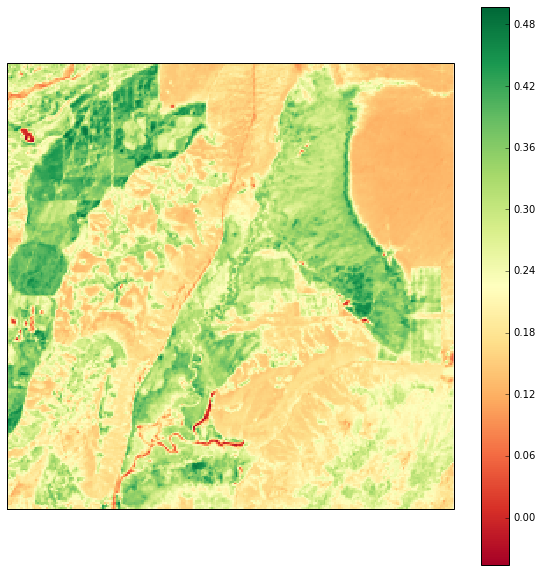

In [5]:
landsat_dname = os.path.join(base_dname, 'Landsat')
scene_name = [f for f in os.listdir(landsat_dname) if f.startswith('LC')][0]                            

landsat_dname = os.path.join(landsat_dname, 'Subset')
landsat_fname = os.path.join(landsat_dname, 'landsat_subset.tif')

landsat = rasterio.open(landsat_fname)
landsat_data = np.squeeze(landsat.read(masked=True))

utm_zone = landsat.crs_wkt.split('UTM zone ')[1].split('N"')[0]
landsat_proj = ccrs.UTM(zone=utm_zone, globe=ccrs.Globe(datum='WGS84',
                                              ellipse='WGS84'))
landsat_extents = [landsat.bounds.left, landsat.bounds.right, 
                   landsat.bounds.bottom, landsat.bounds.top]

print scene_name

%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=landsat_proj)

im = ax.imshow(landsat_data, origin='upper', extent=landsat_extents, transform=landsat_proj, 
          cmap=mpl.cm.RdYlGn, interpolation='none')
plt.colorbar(im)

### Read in 30m elevation data

In [6]:
utm_dname = os.path.join(base_dname, "ArcScene", "InputData", "UTM")
elev_subset_fname = os.path.join(utm_dname, "NED_30m.tif")

elev = rasterio.open(elev_subset_fname)
dem_data = np.squeeze(elev.read(masked=True))

elev_extents = [elev.bounds.left, elev.bounds.right, elev.bounds.bottom, elev.bounds.top]

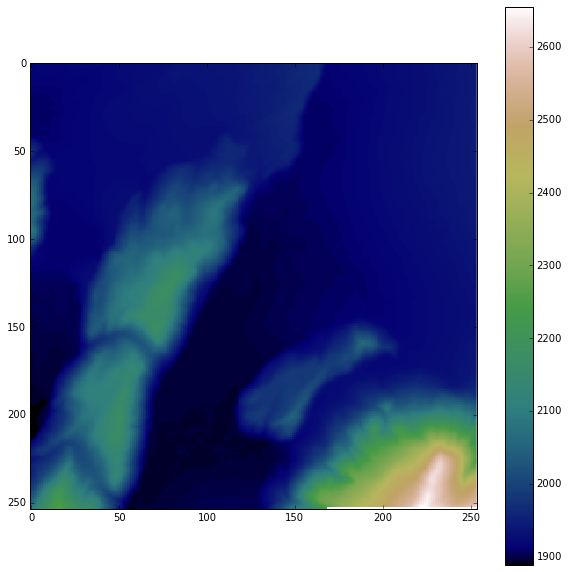

In [7]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()#projection=landsat_proj)
im = ax.imshow(dem_data, origin='upper', #extent=elev_extents, transform=landsat_proj, 
          cmap=mpl.cm.gist_earth, interpolation='none')
plt.colorbar(im)

# Fit a plane to the pixels around a single pixel

In [8]:
from affine import Affine
T1 = landsat.affine * Affine.translation(0,0)

rc2xy = lambda rc: (rc[1], rc[0]) * T1

In [9]:
dem_indices = np.indices(dem_data.shape)
dem_xy = np.apply_along_axis(func1d=rc2xy ,arr=dem_indices, axis=0)

In [10]:
row = 242
col = 127

def get_pix_data(row, col):
    data = dem_data[row-1:row+2, col-1:col+2]
    xy = dem_xy[:, row-1:row+2, col-1:col+2]
    return data, xy

data, xy = get_pix_data(row, col)

In [11]:
def set_aspect_equal_3d(ax):
    """Fix equal aspect bug for 3D plots."""

    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()

    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)

    plot_radius = max([abs(lim - mean_)
                       for lims, mean_ in ((xlim, xmean),
                                           (ylim, ymean),
                                           (zlim, zmean))
                       for lim in lims])

    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])

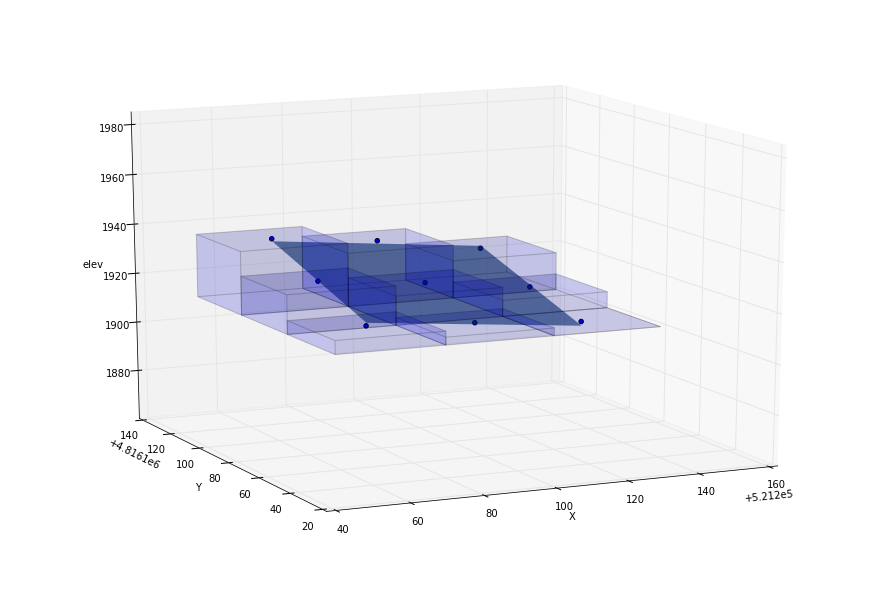

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
# TODO add image and put this code into an appendix at the bottom
from mpl_toolkits.mplot3d import Axes3D

row, col = 210, 131

def plot_3d_slope(row, col, ax, fall_line=False):
    
    data, xy = get_pix_data(row, col)

    X = xy.reshape(2, 9).T
    y = data.flatten()

    X = sm.add_constant(X)
    est = sm.OLS(y, X).fit()

    xx1, xx2 = xy[0,:,:], xy[1,:,:]
    # plot the hyperplane by evaluating the parameters on the grid
    Z = est.params[0] + est.params[1] * xx1 + est.params[2] * xx2

    # plot hyperplane
    surf = ax.plot_surface(xx1, xx2, Z, cmap=plt.cm.RdBu_r, alpha=0.6, linewidth=0)
    
    # plot data points - points over the HP are white, points below are black
    resid = y - est.predict(X)
    ax.scatter(xx1, xx2, y, color='black', alpha=1.0, facecolor='white')


    xpos2 = xx1.flatten()-15
    ypos2 = xx2.flatten()-15
    zpos2 = np.repeat(y.min(), y.flatten().shape).reshape(y.flatten().shape)
    dx2 = 30 * np.ones_like(xx1.flatten())
    dy2 = 30 * np.ones_like(xx2.flatten())
    dz2 = y.flatten() - y.min()

    ax.bar3d(xpos2, ypos2, zpos2, dx2, dy2, dz2, color='b', zsort='average', alpha=0.10)
    
    if fall_line:
        center_x = xpos2[4]+15
        center_y = ypos2[4]+15
        center_z = y.flatten()[4]

        aspect = calc_aspect(est)
        slope = calc_slope(est)
        dx = 30 * np.sin(np.deg2rad(aspect))
        dy = 30 * np.cos(np.deg2rad(aspect))
        fall_x = center_x+dx
        fall_y = center_y+dy

        fall_dist = distance.euclidean((center_x, center_y), 
                                       (fall_x, fall_y))
        fall_z = center_z -(fall_dist*slope)
        ax.plot((center_x, fall_x), 
                (center_y, fall_y), 
                (center_z, fall_z), color='r', lw=6, alpha=0.5)
    
# create matplotlib 3d axes
fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig, azim=-115, elev=15)





# ax.plot((xpos2[4]+15, xpos2[5]+15), 
#         (ypos2[4]+15, ypos2[5]), 
#         (y.flatten()[4], y.flatten()[5]), color='r', solid_capstyle="projecting")


# set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('elev')

plot_3d_slope(row, col, ax)

set_aspect_equal_3d(ax)



In [13]:
def calc_aspect(est):
    params2 = est.params

    intercept, xslope, yslope = params2
    yslope *= -1 #accound for descending utm coordingates

    aspect = 57.29578 * np.arctan2(yslope, -1*xslope)

    if aspect < 0:
        cell = 90.0 - aspect
    elif aspect > 90.0:
        cell = 360.0 - aspect + 90.0
    else:
        cell = 90.0 - aspect

    return cell

def calc_slope(est):
    params2 = est.params
    intercept, xslope, yslope = params2
    yslope *= -1 #accound for descending utm coordingates

    max_slope = (yslope**2 + xslope**2)**.5
    
    return max_slope

# aspect = calc_aspect(est)
# slope = calc_slope(est)

# print calc_aspect(est)
# print calc_slope(est)

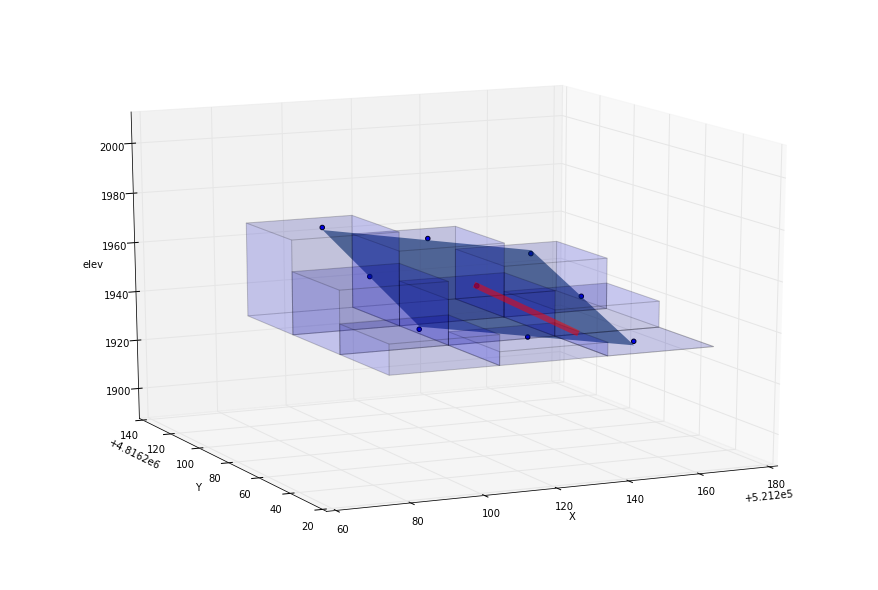

In [14]:
%matplotlib inline
from scipy.spatial import distance

row, col = 207, 132
data, xy = get_pix_data(row, col)

X = xy.reshape(2, 9).T
y = data.flatten()

## fit a OLS model with intercept on TV and Radio
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()

xx1, xx2 = xy[0,:,:], xy[1,:,:]
# plot the hyperplane by evaluating the parameters on the grid
Z = est.params[0] + est.params[1] * xx1 + est.params[2] * xx2

# create matplotlib 3d axes
fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig, azim=-115, elev=15)

# plot hyperplane
surf = ax.plot_surface(xx1, xx2, Z, cmap=plt.cm.RdBu_r, alpha=0.6, linewidth=0)

# plot data points - points over the HP are white, points below are black
resid = y - est.predict(X)
ax.scatter(xx1, xx2, y, color='black', alpha=1.0, facecolor='white')


xpos2 = xx1.flatten()-15
ypos2 = xx2.flatten()-15
zpos2 = np.repeat(y.min(), y.flatten().shape).reshape(y.flatten().shape)
dx2 = 30 * np.ones_like(xx1.flatten())
dy2 = 30 * np.ones_like(xx2.flatten())
dz2 = y.flatten() - y.min()

ax.bar3d(xpos2, ypos2, zpos2, dx2, dy2, dz2, color='b', zsort='average', alpha=0.10)



center_x = xpos2[4]+15
center_y = ypos2[4]+15
center_z = y.flatten()[4]

aspect = calc_aspect(est)
slope = calc_slope(est)
dx = 30 * np.sin(np.deg2rad(aspect))
dy = 30 * np.cos(np.deg2rad(aspect))
fall_x = center_x+dx
fall_y = center_y+dy

fall_dist = distance.euclidean((center_x, center_y), 
                               (fall_x, fall_y))
fall_z = center_z -(fall_dist*slope)
ax.plot((center_x, fall_x), 
        (center_y, fall_y), 
        (center_z, fall_z), color='r', lw=6, alpha=0.5)

# set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('elev')

    
set_aspect_equal_3d(ax)

## Now that we've got all that worked out run it through all the landsat pixels in our image

In [ ]:
url = "http://phenocam.sr.unh.edu/webcam/browse/{}/{}/{:02d}/{:02d}"
dt = closest_date
url.format(site_name, dt.year, dt.month, dt.day)

print pyphenocam.config.get_config_fname()

In [15]:
landsat_fishnet_fname = os.path.join(base_dname, "ArcScene", "landsat_fishnet.bmp")
landsat_index_fname = os.path.join(base_dname, "ArcScene", "landsat_subset_index.bmp")

phenosite = pyphenocam.dataaccess.get_site(site_name)

closest_date = datetime.datetime(2015, 1, 1, 12) + datetime.timedelta(280)
print closest_date
sample_photo_fname = phenosite.get_closest_fname(closest_date)

2015-10-08 12:00:00


Extracted exposure:  40


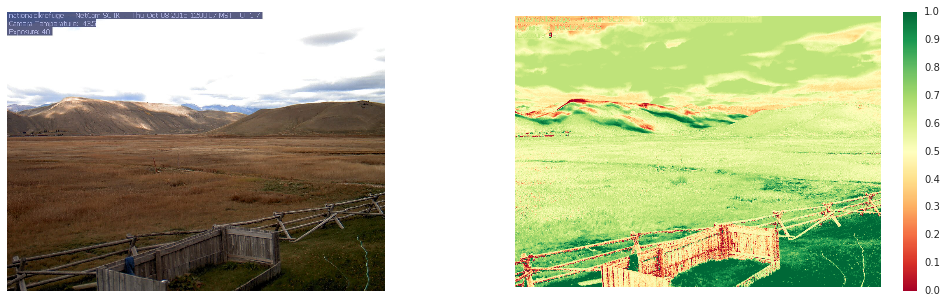

In [114]:
%matplotlib inline
fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(121)
sample_photo_fname = phenosite.get_closest_fname(closest_date)
local_fname = phenosite.get_local_image_fname(sample_photo_fname)
local_fname_ir = phenosite.get_local_image_fname(sample_photo_fname, IR=True)
sample_image = phenosite.get_local_image(sample_photo_fname)
sample_image_ir = phenosite.get_local_image(sample_photo_fname, IR=True)

ax.imshow(sample_image)
pyphenocam.plotting.format_photo_axes(ax)

corrected_ndvi = pyphenocam.imageprocessing._get_corrected_ndvi(local_fname, 
                                                                local_fname_ir, 
                                                                float(exposure), 
                                                                float(exposure_ir))
ax2 = fig.add_subplot(122)
im = ax2.imshow(corrected_ndvi, vmin=0, cmap=mpl.cm.RdYlGn)
fig.colorbar(im)
pyphenocam.plotting.format_photo_axes(ax2)
exposure = pyphenocam.headerextraction.get_exposure(local_fname)
exposure_ir = pyphenocam.headerextraction.get_exposure(local_fname_ir)
print "Extracted exposure: ", exposure

In [17]:
index_grid = skimage.io.imread(landsat_index_fname)
index_grid = trans.resize(index_grid, (sample_image.shape[0], sample_image.shape[1], 3), preserve_range=True, order=0)

index_grid = np.ma.masked_where(index_grid > 254, index_grid)

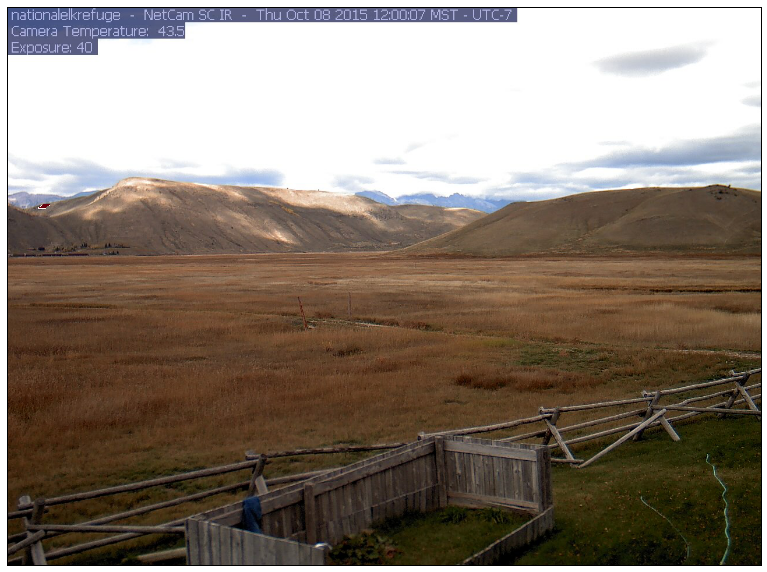

In [18]:
single_pixel = np.logical_and(index_grid[:,:,0]==54, index_grid[:,:,1]==148)

single_pixel = np.ma.asarray(trans.resize(single_pixel, 
            (sample_image.shape[0], sample_image.shape[1]), preserve_range=False))#[:,:,1]

single_pixel.mask = single_pixel==False

fig, ax = plt.subplots(1, figsize=(20,10))
ax.imshow(sample_image)
ax.imshow(single_pixel, alpha = 1.0, cmap=mpl.cm.Reds, interpolation='none')
pyphenocam.plotting.format_photo_axes(ax)

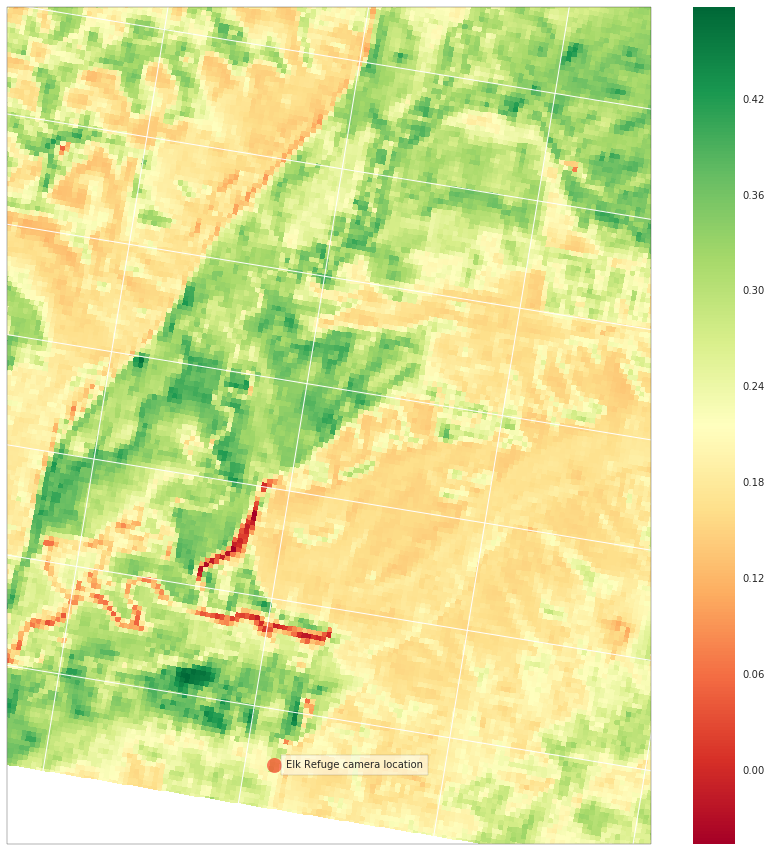

In [164]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

ax_proj = ccrs.LambertConformal()
landsat_proj = ccrs.UTM(zone=12, globe=ccrs.Globe(datum='WGS84',
                                              ellipse='WGS84'))
geodetic = ccrs.Geodetic()

fig = plt.figure(figsize=(15, 15))
ax_extent = [phenosite.x - 0.02, phenosite.x + 0.02, phenosite.y - 0.002, phenosite.y + 0.040]

landsat_extents = [landsat.bounds.left, landsat.bounds.right, landsat.bounds.bottom, landsat.bounds.top]

ax = plt.axes(projection=ax_proj)
ax.set_extent(ax_extent, ccrs.Geodetic())
im = ax.imshow(landsat_data, origin='upper', extent=landsat_extents, transform=landsat_proj, interpolation='none', 
          cmap=mpl.cm.RdYlGn)

# # ax.set_xmargin(0.05)
# # ax.set_ymargin(0.10)

# mark a known place to help us geo-locate ourselves
locx, locy = list(ax_proj.transform_point(phenosite.x, phenosite.y, geodetic))
ax.plot(locx, locy, 'bo', markersize=15, color='red', alpha=0.5)
ax.text(locx+75, locy-15, 'Elk Refuge camera location', bbox={'facecolor':'white', 'alpha':0.5, 'pad':5})

ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.BORDERS)
ax.gridlines()
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray')
plt.colorbar(im)

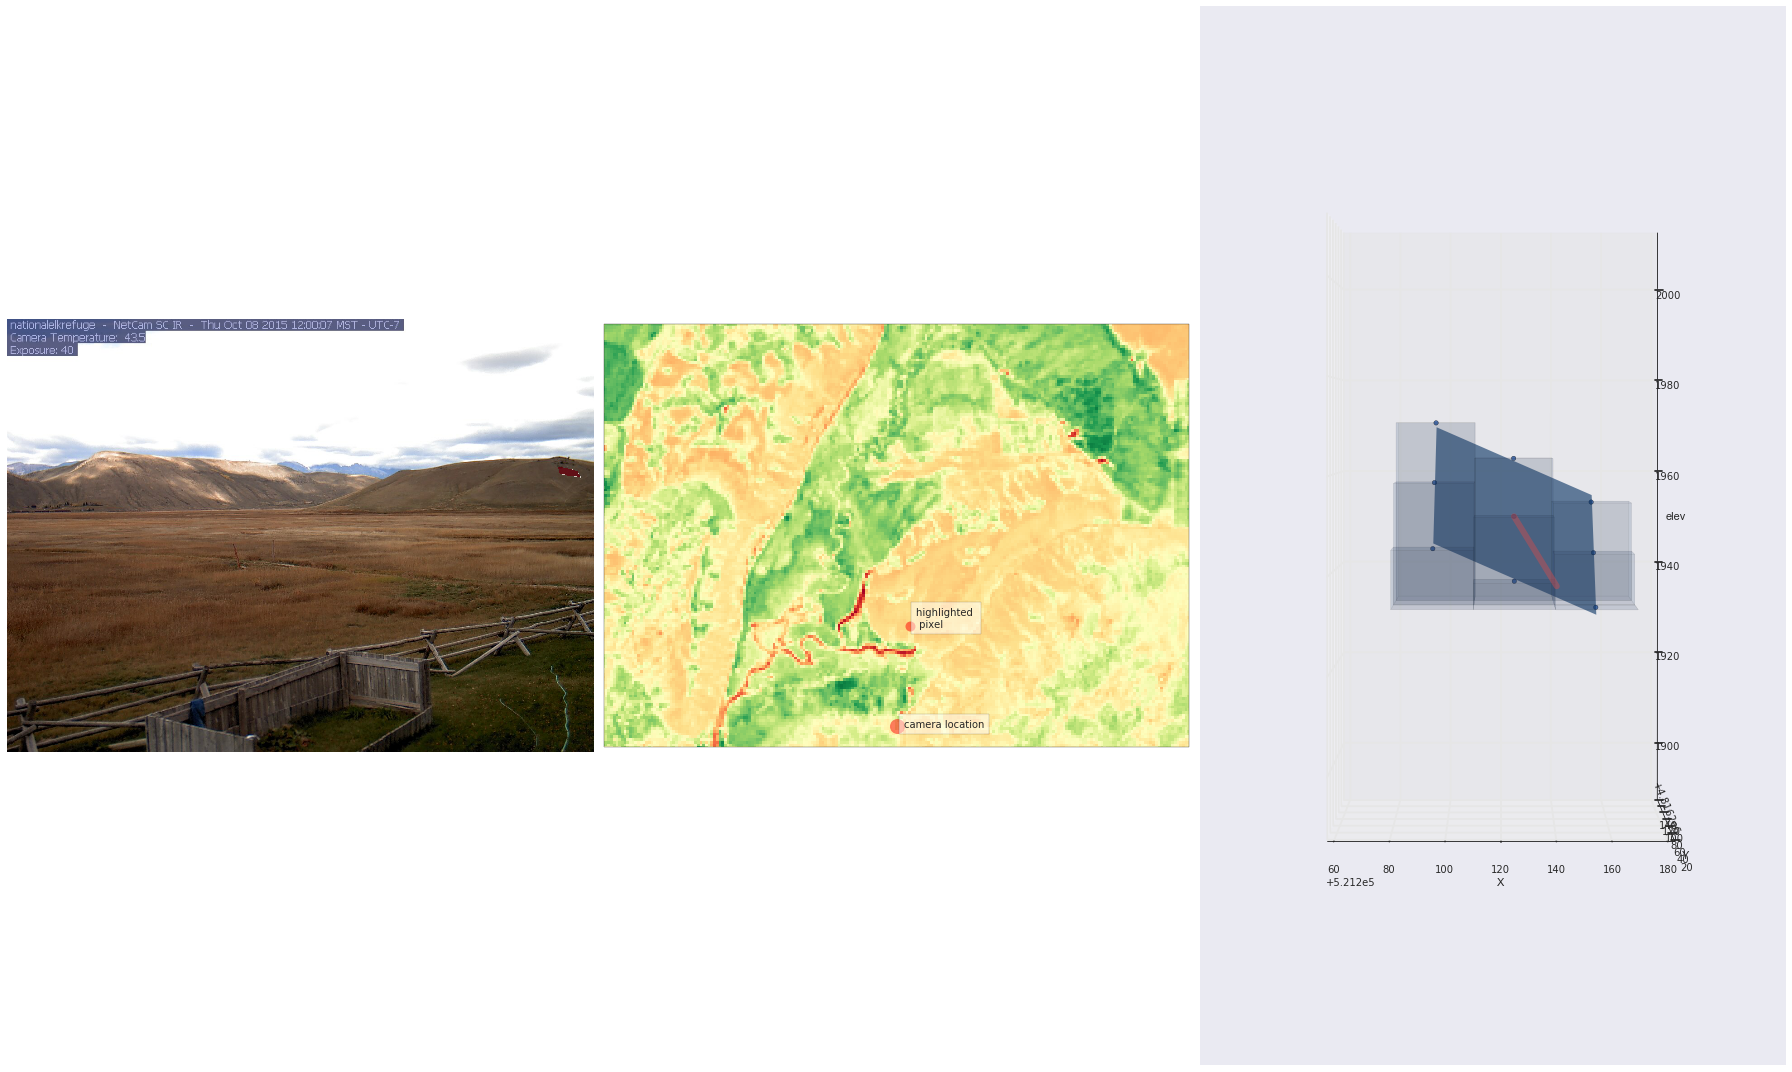

In [165]:
%matplotlib inline
from ipywidgets import interactive

col_index, row_index = 0,0
#col_index=127, row_index=250
def plot_one(col_index=132, row_index=207):
    single_pixel = np.logical_and(index_grid[:,:,0]==col_index, index_grid[:,:,1]==row_index)

    single_pixel = np.ma.asarray(trans.resize(single_pixel, 
                (sample_image.shape[0], sample_image.shape[1]), preserve_range=False))#[:,:,1]

    single_pixel.mask = single_pixel==False

    fig = plt.figure(figsize=(25, 15))
    ax = plt.subplot(131)
    ax.imshow(sample_image)
    ax.imshow(single_pixel, alpha = 0.75, cmap=mpl.cm.Reds, interpolation='none')
    pyphenocam.plotting.format_photo_axes(ax)

    ax_proj = landsat_proj
    ax2 = plt.subplot(132, projection=ax_proj)
    ax_extent = [phenosite.x - 0.04, phenosite.x + 0.04, phenosite.y - 0.002, phenosite.y + 0.040]
    ax2.set_extent(ax_extent, ccrs.Geodetic())
    ax2.imshow(landsat_data, origin='upper', extent=landsat_extents, transform=landsat_proj, interpolation='none', 
          cmap=mpl.cm.RdYlGn)
    colx, coly = landsat.affine * (col_index, row_index)
    colx += landsat.transform[1]/2.
    coly += landsat.transform[5]/2.
    
    colxgeo, colygeo = list(ax_proj.transform_point(colx, coly, landsat_proj))
    ax2.plot(colxgeo, colygeo, 'bo', markersize=10, color='red', alpha=0.5)
    ax2.text(colxgeo+75, colygeo-15, 'highlighted \n pixel', bbox={'facecolor':'white', 'alpha':0.5, 'pad':5})

    # mark a known place to help us geo-locate ourselves
    locx, locy = list(ax_proj.transform_point(phenosite.x, phenosite.y, geodetic))
    ax2.plot(locx, locy, 'bo', markersize=15, color='red', alpha=0.5)
    ax2.text(locx+75, locy-10, 'camera location', bbox={'facecolor':'white', 'alpha':0.5, 'pad':5})

    ax3 = fig.add_subplot(1, 3, 3, projection='3d', azim=-90, elev=1)
    
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('elev')

    plot_3d_slope(row_index, col_index, ax3, fall_line=True)

    set_aspect_equal_3d(ax3)

    
    plt.tight_layout()
    
interactive(plot_one, col_index=(0, landsat.shape[0], 1), row_index=(0, landsat.shape[1], 1))

In [21]:
def get_slope_aspect(col, row):
    data, xy = get_pix_data(row, col)

    X = xy.reshape(2, 9).T
    y = data.flatten()

    X = sm.add_constant(X)
    est = sm.OLS(y, X).fit()

    aspect = calc_aspect(est)
    slope = calc_slope(est)
    return slope, aspect

In [171]:

#this isn't terribly efficient but a good demonstration/validation of the technique \n",
data = np.array(index_grid[:, :, :2]).astype(np.uint8)
dtype = data.dtype.descr * 2
struct = data.view(dtype)
uniq = np.unique(struct)

results = {}
mapped_output = np.zeros(np.squeeze(index_grid[:,:,1]).shape)

i = 0
for col, row in uniq:
#     print col, row,
    print ".",
    
    single_pixel = np.logical_and(index_grid[:,:,0]==col, index_grid[:,:,1]==row)
    single_pixel = np.ma.asarray(trans.resize(single_pixel, 
                    (sample_image.shape[0], sample_image.shape[1]), preserve_range=False))#[:,:,1]
    phenopixcount = np.count_nonzero(single_pixel)
    try:
        landsatx, landsaty = dem_xy[:, row, col]
        slope, aspect = get_slope_aspect(col=col, row=row)
        landsat_ndvi = landsat_data[row, col]
        phenocam_ndvi = np.mean(corrected_ndvi[single_pixel>0.95])
        results[i] = [col, row, phenopixcount, landsatx, landsaty, slope, aspect, landsat_ndvi, phenocam_ndvi]
        mapped_output[single_pixel>0.95] = landsat_ndvi
    except IndexError:
        print "skipping", col, row
    i+=1
    


. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [172]:
import pandas as pd
data = pd.DataFrame.from_dict(results, orient='index')
data.columns = ["col", "row", "phenopixcount", "landsatx", "landsaty", "slope", "aspect", "landsat_ndvi", "phenocam_ndvi"]
data

,col,row,phenopixcount,landsatx,landsaty,slope,aspect,landsat_ndvi,phenocam_ndvi
0,50,148,4,518865.0,4818045.0,0.351355,229.950970,0.157935,0.521943
1,51,147,14,518895.0,4818075.0,0.279347,241.181395,0.152381,0.498634
2,51,148,37,518895.0,4818045.0,0.325250,214.919030,0.173566,0.498068
3,51,149,13,518895.0,4818015.0,0.471193,195.896282,0.176286,0.595950
4,52,147,26,518925.0,4818075.0,0.266768,210.488439,0.156121,0.556708
5,52,148,69,518925.0,4818045.0,0.333626,189.360040,0.181718,0.467444
6,52,149,50,518925.0,4818015.0,0.485317,179.361721,0.173437,0.296868
7,53,146,6,518955.0,4818105.0,0.256549,224.051942,0.144008,0.514904
8,53,147,53,518955.0,4818075.0,0.348917,190.469416,0.163911,0.519119
9,53,148,93,518955.0,4818045.0,0.403093,177.139348,0.183377,0.320005


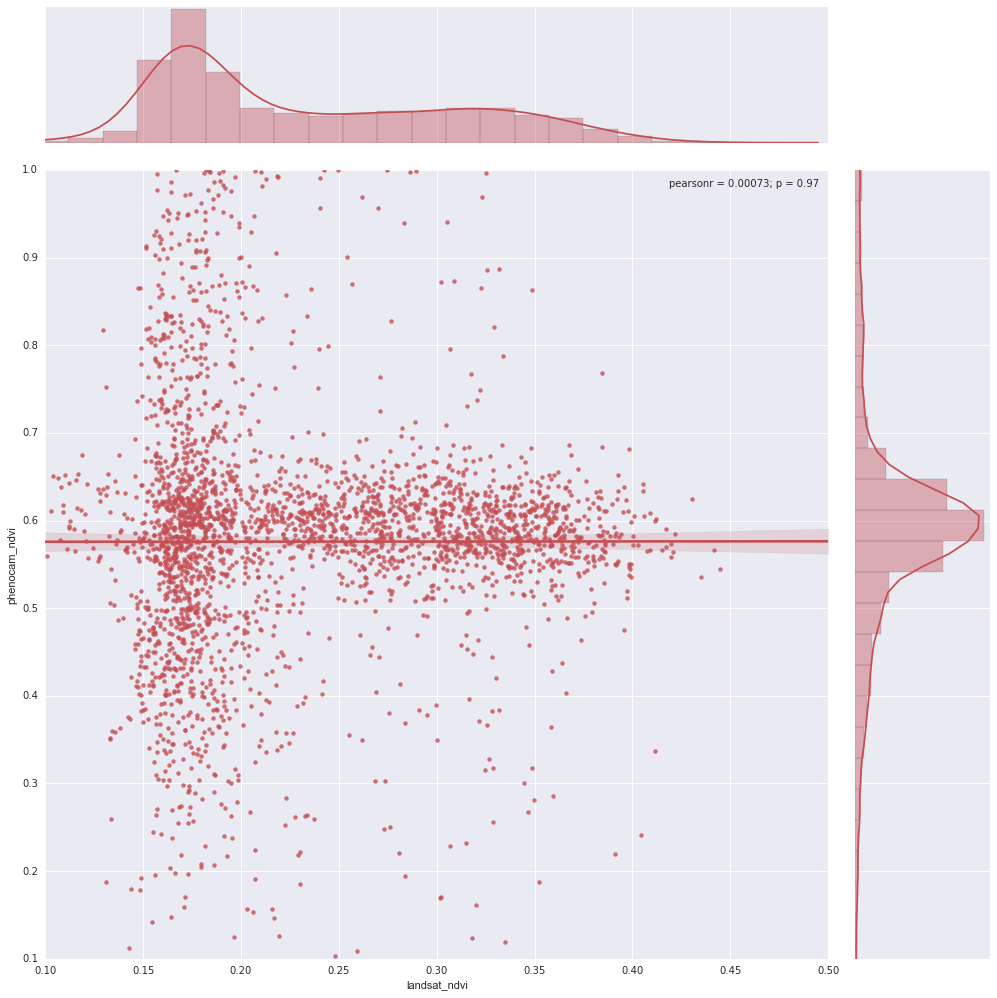

In [183]:
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

g = sns.jointplot("landsat_ndvi", "phenocam_ndvi", data=data, kind="reg",
                  xlim=(0.1, 0.5), ylim=(0.1, 1.), color="r", size=14)

In [178]:
corrected_ndvi_m = np.ma.masked_where(index_grid.mask[:,:,0], corrected_ndvi)
mapped_output_m = np.ma.masked_where(index_grid.mask[:,:,0], mapped_output)

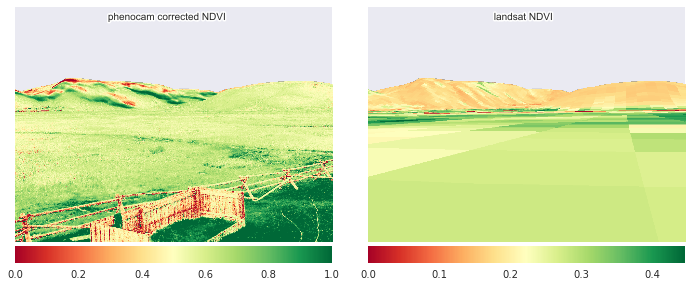

In [179]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

im = np.arange(100)
im.shape = 10, 10

fig = plt.figure(1, figsize=(12, 6))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                 label_mode="1",
                    share_all=True,
                    cbar_location="bottom",
                    cbar_mode="each",
                    cbar_size="7%",
                    cbar_pad="2%",
                    )

#     Z, extent = get_demo_image()
#     for i in range(4):
#         im = grid[i].imshow(Z, extent=extent, interpolation="nearest")
#         grid.cbar_axes[i].colorbar(im)

#     for cax in grid.cbar_axes:
#         cax.toggle_label(False)

#     # This affects all axes because we set share_all = True.
#     grid.axes_llc.set_xticks([-2, 0, 2])
#     grid.axes_llc.set_yticks([-2, 0, 2])
# )

for i in range(2):
    pyphenocam.plotting.format_photo_axes(grid[i])
    
im1 = grid[0].imshow(corrected_ndvi_m, vmin=0, cmap=mpl.cm.RdYlGn)  # The AxesGrid object work as a list of axes.
im2 = grid[1].imshow(mapped_output_m, vmin=0, cmap=mpl.cm.RdYlGn)

grid.cbar_axes[0].colorbar(im1)
grid.cbar_axes[1].colorbar(im2)

pyphenocam.plotting.add_inner_title(grid[0], "phenocam corrected NDVI", 9)
pyphenocam.plotting.add_inner_title(grid[1], "landsat NDVI", 9)

plt.show()

In [185]:
data.to_csv(os.path.join(base_dname, scene_name + "_results.csv"))

### read in the MODIS data

In [9]:
modis_dname = os.path.join(output_dir, 'MODIS', 'subset')
modis_subset_fname = os.path.join(modis_dname, "modis_subset.tif")

In [11]:
modis = rasterio.open(modis_subset_fname)
modis_data = np.squeeze(modis.read(masked=True))
modis_proj = cartopy.crs.Sinusoidal.MODIS

modis_extents = [modis.bounds.left, modis.bounds.right, modis.bounds.bottom, modis.bounds.top]

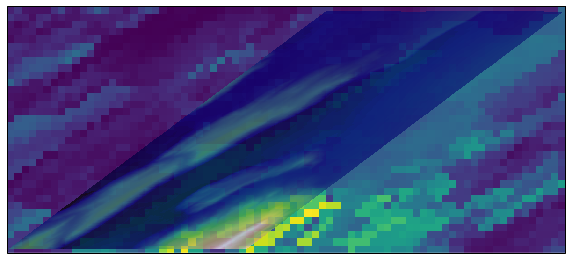

In [25]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=modis_proj)
im = ax.imshow(modis_data, origin='upper', extent=modis_extents, transform=modis_proj, 
          cmap=mpl.cm.viridis, interpolation='none')
ax.imshow(dem_data, origin='upper', extent=elev_extents, transform=landsat_proj, 
          cmap=mpl.cm.gist_earth, interpolation='none', alpha=0.7)


# Calculate the slope and aspect under a single modis pixel

In [13]:
modis_index_subset_fname = os.path.join(modis_dname, "modis_subset_index.tif")
modis_index = rasterio.open(modis_index_subset_fname)
modis_index_data = np.squeeze(modis_index.read(masked=True))

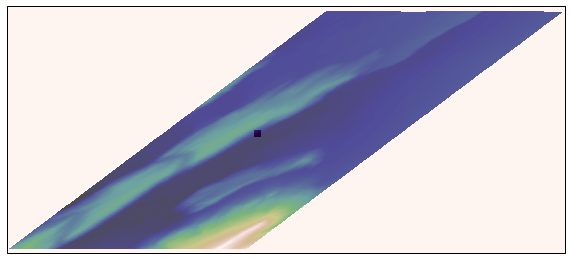

In [26]:
selected_pixel = np.zeros(modis_data.shape)
selected_pixel[17, 34] = 1.

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=modis_proj)
im = ax.imshow(selected_pixel, origin='upper', extent=modis_extents, transform=modis_proj, 
          cmap=mpl.cm.Reds, interpolation='none')
ax.imshow(dem_data, origin='upper', extent=elev_extents, transform=landsat_proj, 
          cmap=mpl.cm.gist_earth, interpolation='none', alpha=0.7)

### Transform the selected pixels corner cordinates into the elevation crs

In [15]:
from affine import Affine
T1 = modis.affine * Affine.translation(0,0)

rc2xy = lambda r, c: (c, r) * T1

In [16]:
r, c = 17, 34

sel_pixulx, sel_pixuly = rc2xy (r+0, c+0)
sel_pixllx, sel_pixlly = rc2xy (r+1, c+0)
sel_pixurx, sel_pixury = rc2xy (r+0, c+1)
sel_pixlrx, sel_pixlry = rc2xy (r+1, c+1)

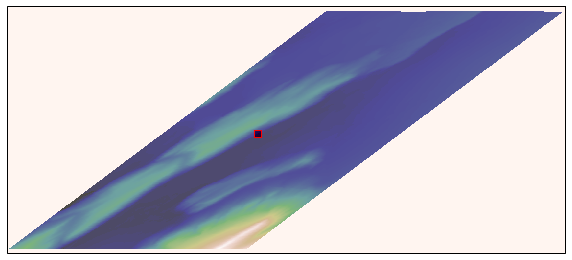

In [59]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=modis_proj)
im = ax.imshow(selected_pixel, origin='upper', extent=modis_extents, transform=modis_proj, 
          cmap=mpl.cm.Reds, interpolation='none')
ax.imshow(dem_data, origin='upper', extent=elev_extents, transform=landsat_proj, 
          cmap=mpl.cm.gist_earth, interpolation='none', alpha=0.7)

ax.plot([sel_pixulx,sel_pixurx], [sel_pixuly, sel_pixury], 'k-', lw=1, c='red', transform=modis_proj)
ax.plot([sel_pixurx,sel_pixlrx], [sel_pixury, sel_pixlry], 'k-', lw=1, c='red', transform=modis_proj)
ax.plot([sel_pixlrx,sel_pixllx], [sel_pixlry, sel_pixlly], 'k-', lw=1, c='red', transform=modis_proj)
ax.plot([sel_pixllx,sel_pixulx], [sel_pixlly, sel_pixuly], 'k-', lw=1, c='red', transform=modis_proj)

In [64]:
dem_urx, dem_ury = list(landsat_proj.transform_point(sel_pixurx, sel_pixury, modis_proj))
dem_llx, dem_lly = list(landsat_proj.transform_point(sel_pixllx, sel_pixlly, modis_proj))
dem_ulx, dem_uly = list(landsat_proj.transform_point(sel_pixulx, sel_pixuly, modis_proj))
dem_lrx, dem_lry = list(landsat_proj.transform_point(sel_pixlrx, sel_pixlry, modis_proj))

In [65]:
dem_urx, dem_ury

(520341.93027473486, 4818685.86299797)

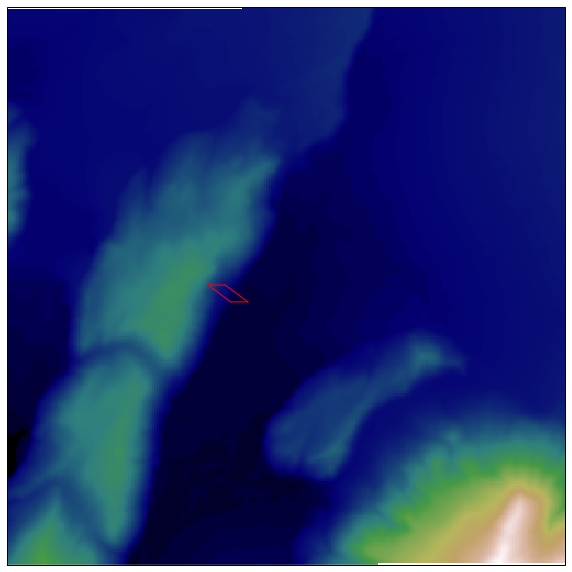

In [66]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=landsat_proj)

ax.imshow(dem_data, origin='upper', extent=elev_extents, transform=landsat_proj, 
          cmap=mpl.cm.gist_earth, interpolation='none')

ax.plot([dem_ulx,dem_urx], [dem_uly, dem_ury], 'k-', lw=1, c='red', transform=landsat_proj)
ax.plot([dem_urx,dem_lrx], [dem_ury, dem_lry], 'k-', lw=1, c='red', transform=landsat_proj)
ax.plot([dem_lrx,dem_llx], [dem_lry, dem_lly], 'k-', lw=1, c='red', transform=landsat_proj)
ax.plot([dem_llx,dem_ulx], [dem_lly, dem_uly], 'k-', lw=1, c='red', transform=landsat_proj)

In [67]:
from rasterio.features import rasterize
from shapely.geometry import Polygon, mapping

poly = Polygon(((dem_ulx, dem_uly), (dem_urx, dem_ury), (dem_lrx, dem_lry), (dem_llx, dem_lly)))
output = rasterize([poly], transform=elev.transform, out_shape=dem_data.shape)

dem_pix_subset = dem_data.copy()
dem_pix_subset.mask = output==0

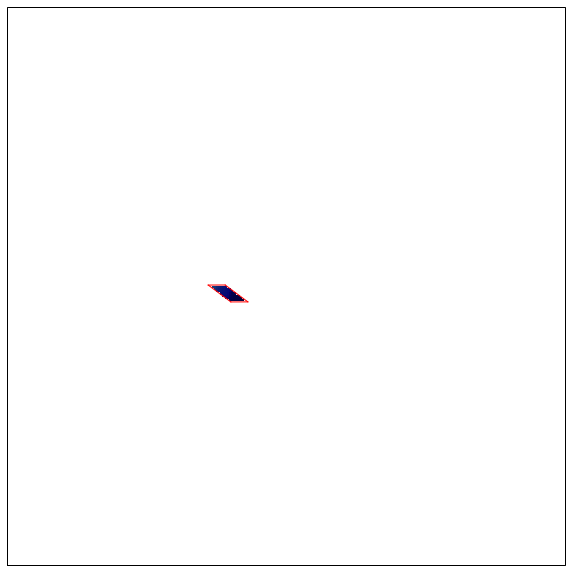

In [69]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=landsat_proj)

ax.imshow(dem_pix_subset, origin='upper', extent=elev_extents, transform=landsat_proj, 
          cmap=mpl.cm.gist_earth, interpolation='none',
         vmax=dem_data.max(), vmin=dem_data.min())

ax.plot([dem_ulx,dem_urx], [dem_uly, dem_ury], 'k-', lw=1, c='red', transform=landsat_proj)
ax.plot([dem_urx,dem_lrx], [dem_ury, dem_lry], 'k-', lw=1, c='red', transform=landsat_proj)
ax.plot([dem_lrx,dem_llx], [dem_lry, dem_lly], 'k-', lw=1, c='red', transform=landsat_proj)
ax.plot([dem_llx,dem_ulx], [dem_lly, dem_uly], 'k-', lw=1, c='red', transform=landsat_proj)

In [42]:
from affine import Affine
T1 = landsat.affine * Affine.translation(0,0)

rc2xy = lambda rc: (rc[1], rc[0]) * T1

In [38]:
dem_indices = np.indices(dem_data.shape)
dem_xy = np.apply_along_axis(func1d=rc2xy ,arr=dem_indices, axis=0)

In [28]:
rc2xy(1, 1)

(517395.0, 4822455.0)

In [55]:
row = 41
col = 81

data = dem_data[row-1:row+2, col-1:col+2]
xy = dem_xy[:, row-1:row+2, col-1:col+2]

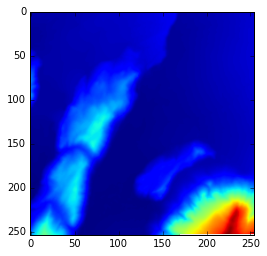

In [31]:
plt.imshow(dem_data)

In [56]:
xy

array([[[  519765.,   519795.,   519825.],
        [  519765.,   519795.,   519825.],
        [  519765.,   519795.,   519825.]],

       [[ 4821285.,  4821285.,  4821285.],
        [ 4821255.,  4821255.,  4821255.],
        [ 4821225.,  4821225.,  4821225.]]])

In [34]:
np.indices(data)

TypeError: Only length-1 arrays can be converted to Python scalars

In [54]:
dem_xy[:, 1, 1]

array([  517395.,  4822455.])

In [52]:
dem_xy.shape

(2L, 254L, 254L)

In [49]:
dem_indices.shape

(2L, 254L, 254L)

In [77]:
import numpy as np
import statsmodels.api as sm

# Generate artificial data (2 regressors + constant)
nobs = 100
X = xy.reshape(2, 9).T
X = sm.add_constant(X)
y = data.flatten()

e = np.random.random(nobs)
y = np.dot(X, beta) + e

# Fit regression model
results = sm.OLS(y, X).fit()

# Inspect the results
print results.summary()


NameError: name 'nobs' is not defined

In [63]:
X = np.random.random((100, 2))
X.shape

(100L, 2L)

In [76]:
data.flatten()

masked_array(data = [1927.6507568359375 1927.958740234375 1928.2967529296875 1927.552734375
 1927.8743896484375 1928.2237548828125 1927.410400390625 1927.7431640625
 1928.089599609375],
             mask = [False False False False False False False False False],
       fill_value = -9999.0)

array([[  519765.,  4821285.],
       [  519795.,  4821285.],
       [  519825.,  4821285.],
       [  519765.,  4821255.],
       [  519795.,  4821255.],
       [  519825.,  4821255.],
       [  519765.,  4821225.],
       [  519795.,  4821225.],
       [  519825.,  4821225.]])

In [1]:
%matplotlib qt4
import matplotlib.pyplot as plt
# TODO add image and put this code into an appendix at the bottom
from mpl_toolkits.mplot3d import Axes3D

X = xy.reshape(2, 9).T
y = data.flatten()

## fit a OLS model with intercept on TV and Radio
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()

## Create the 3d plot -- skip reading this
# TV/Radio grid for 3d plot
xx1, xx2 = xy[0,:,:], xy[1,:,:]
# plot the hyperplane by evaluating the parameters on the grid
Z = est.params[0] + est.params[1] * xx1 + est.params[2] * xx2

# create matplotlib 3d axes
fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig, azim=-115, elev=15)

# plot hyperplane
surf = ax.plot_surface(xx1, xx2, Z, cmap=plt.cm.RdBu_r, alpha=0.6, linewidth=0)

# plot data points - points over the HP are white, points below are black
resid = y - est.predict(X)
ax.scatter(xx1, xx2, y, color='black', alpha=1.0, facecolor='white')


xpos2 = xx1.flatten()-5
ypos2 = xx2.flatten()-5
zpos2 = np.repeat(y.min(), y.flatten().shape).reshape(y.flatten().shape)
dx2 = 15 * np.ones_like(xx1.flatten())
dy2 = 15 * np.ones_like(xx2.flatten())
dz2 = y.flatten() - y.min()

ax.bar3d(xpos2, ypos2, zpos2, dx2, dy2, dz2, color='b', zsort='average', alpha=0.05)

# set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('elev')

NameError: name 'xy' is not defined

In [134]:
y.min()

1927.4104

In [92]:
xpos

array([ 0.26733116,  1.25870241,  2.25007367,  3.24144493,  0.26733116,
        1.25870241,  2.25007367,  3.24144493,  0.26733116,  1.25870241,
        2.25007367,  3.24144493,  0.26733116,  1.25870241,  2.25007367,
        3.24144493])

In [101]:
xpos2 = xx1.flatten()

In [116]:
ypos.shape

(16L,)

In [103]:
ypos2 = xx2.flatten()

In [93]:
zpos

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.])

In [105]:
np.zeros(y.flatten().shape)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [84]:
xx2[:2,:2]

array([[ 0.       ,  0.       ],
       [ 0.5010101,  0.5010101]])

In [98]:
xx1.flatten()

array([ 519765.,  519795.,  519825.,  519765.,  519795.,  519825.,
        519765.,  519795.,  519825.])

In [112]:
np.array(y.flatten())

array([ 1927.65075684,  1927.95874023,  1928.29675293,  1927.55273438,
        1927.87438965,  1928.22375488,  1927.41040039,  1927.74316406,
        1928.08959961], dtype=float32)

In [115]:
dz.shape

(16L,)

In [117]:
np.array(y.flatten()).shape

(9L,)

In [121]:
for thing in [xpos2, ypos2, zpos2, dx2, dy2, dz2]:
    print thing.shape

(9L,)
(9L,)
(9L,)
(1L,)
(1L,)
(9L,)


In [123]:
dx.shape

(16L,)

In [127]:
np.ones_like(xx1.flatten())

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

(9L,)